In [1]:
!pip install -q tensorflow

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 66.0MB/s 
     |████████████████████████████████| 3.8MB 68.8MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import yfinance as yf
from sklearn import preprocessing


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 16, 10

#RANDOM_SEED = 42

#np.random.seed(RANDOM_SEED)
#tf.random.set_seed(RANDOM_SEED)

### Get necessary data

In [ ]:
#Get data
data=yf.download("GOOGL", period="1y", interval="1d")
df = pd.DataFrame(data)
df.head()

#Remove unnecessary columns
df.drop(columns=[
    'Adj Close'],
    inplace=True)

df.head()

### Convert data/time to useable format and normalize data

In [ ]:
date_time = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

df.head()

# Data Preprocessing

In [5]:
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_norm = pd.DataFrame(x_scaled, columns = df.columns)

,sine
0.0,0.248357
0.1,0.030701
0.2,0.522514
0.3,1.057035
0.4,0.272342


In [6]:
train_size = int(len(df_norm) * 0.8)
test_size = len(df_norm) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df_norm)]
print(len(train), len(test))

800 200


In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.Close, time_steps)
X_test, y_test = create_dataset(test, test.Close, time_steps)

print(X_train.shape, y_train.shape)

(790, 10, 1) (790,)


In [9]:
X_train[0]

array([[0.24835708],
       [0.03070127],
       [0.5225136 ],
       [1.05703513],
       [0.27234165],
       [0.36235706],
       [1.35424888],
       [1.02793505],
       [0.4826189 ],
       [1.05460693]])

In [10]:
y_train[0]

0.6097621384016654

# Modeling

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.001))

## Training

In [12]:
EPOCHS = 500

history = model.fit(
    X_train, y_train, 
    epochs=EPOCHS, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False
)

Train on 711 samples, validate on 79 samples
Epoch 1/30
711/711 [==============================] - 7s 10ms/sample - loss: 0.4394 - val_loss: 0.3740
Epoch 2/30
711/711 [==============================] - 0s 235us/sample - loss: 0.3324 - val_loss: 0.3310
Epoch 3/30
711/711 [==============================] - 0s 228us/sample - loss: 0.3219 - val_loss: 0.3254
Epoch 4/30
711/711 [==============================] - 0s 366us/sample - loss: 0.3199 - val_loss: 0.3217
Epoch 5/30
711/711 [==============================] - 0s 230us/sample - loss: 0.3184 - val_loss: 0.3191
Epoch 6/30
711/711 [==============================] - 0s 273us/sample - loss: 0.3173 - val_loss: 0.3171
Epoch 7/30
711/711 [==============================] - 0s 283us/sample - loss: 0.3165 - val_loss: 0.3154
Epoch 8/30
711/711 [==============================] - 0s 387us/sample - loss: 0.3157 - val_loss: 0.3140
Epoch 9/30
711/711 [==============================] - 0s 344us/sample - loss: 0.3150 - val_loss: 0.3126
Epoch 10/30
711/711 

## Evaluation

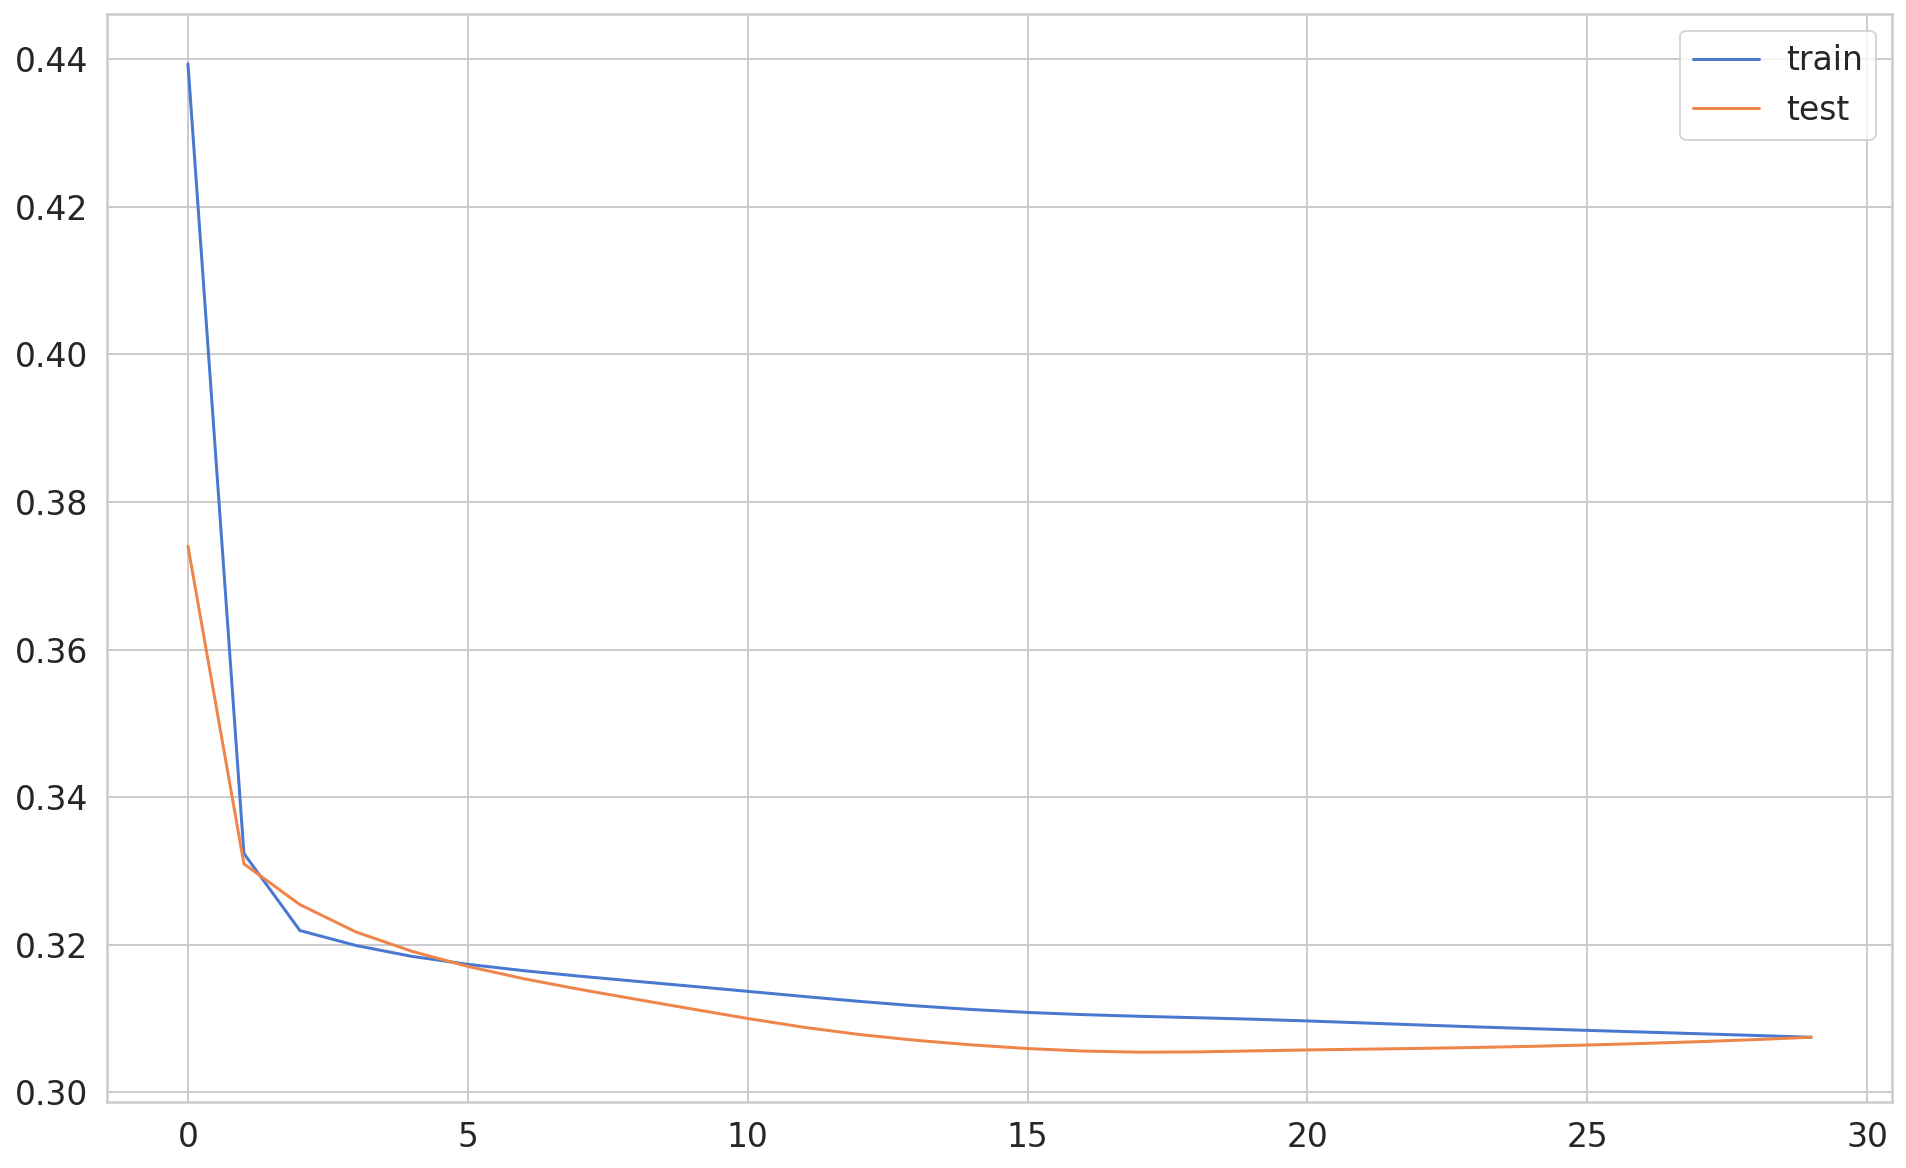

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
y_pred = model.predict(X_test)

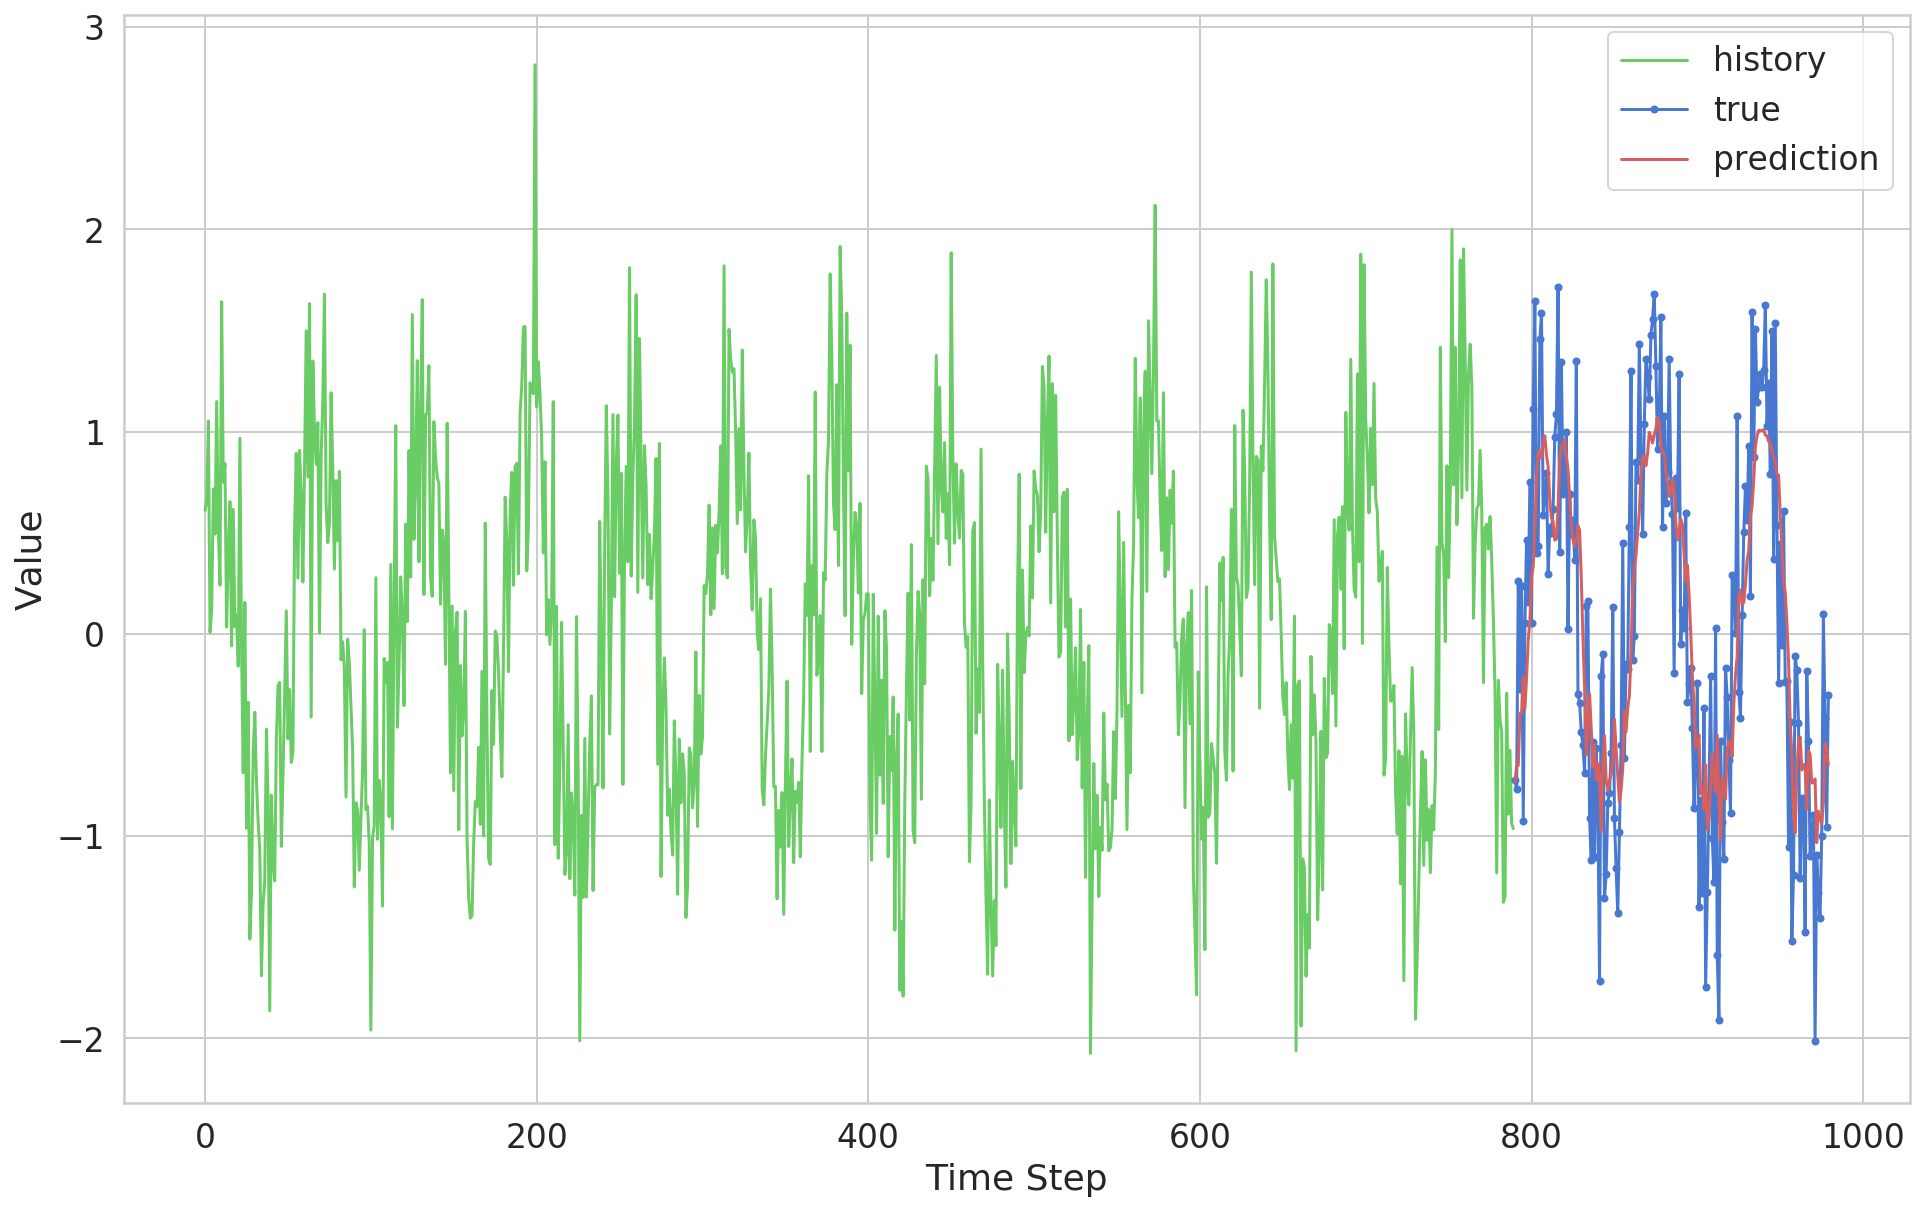

In [15]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

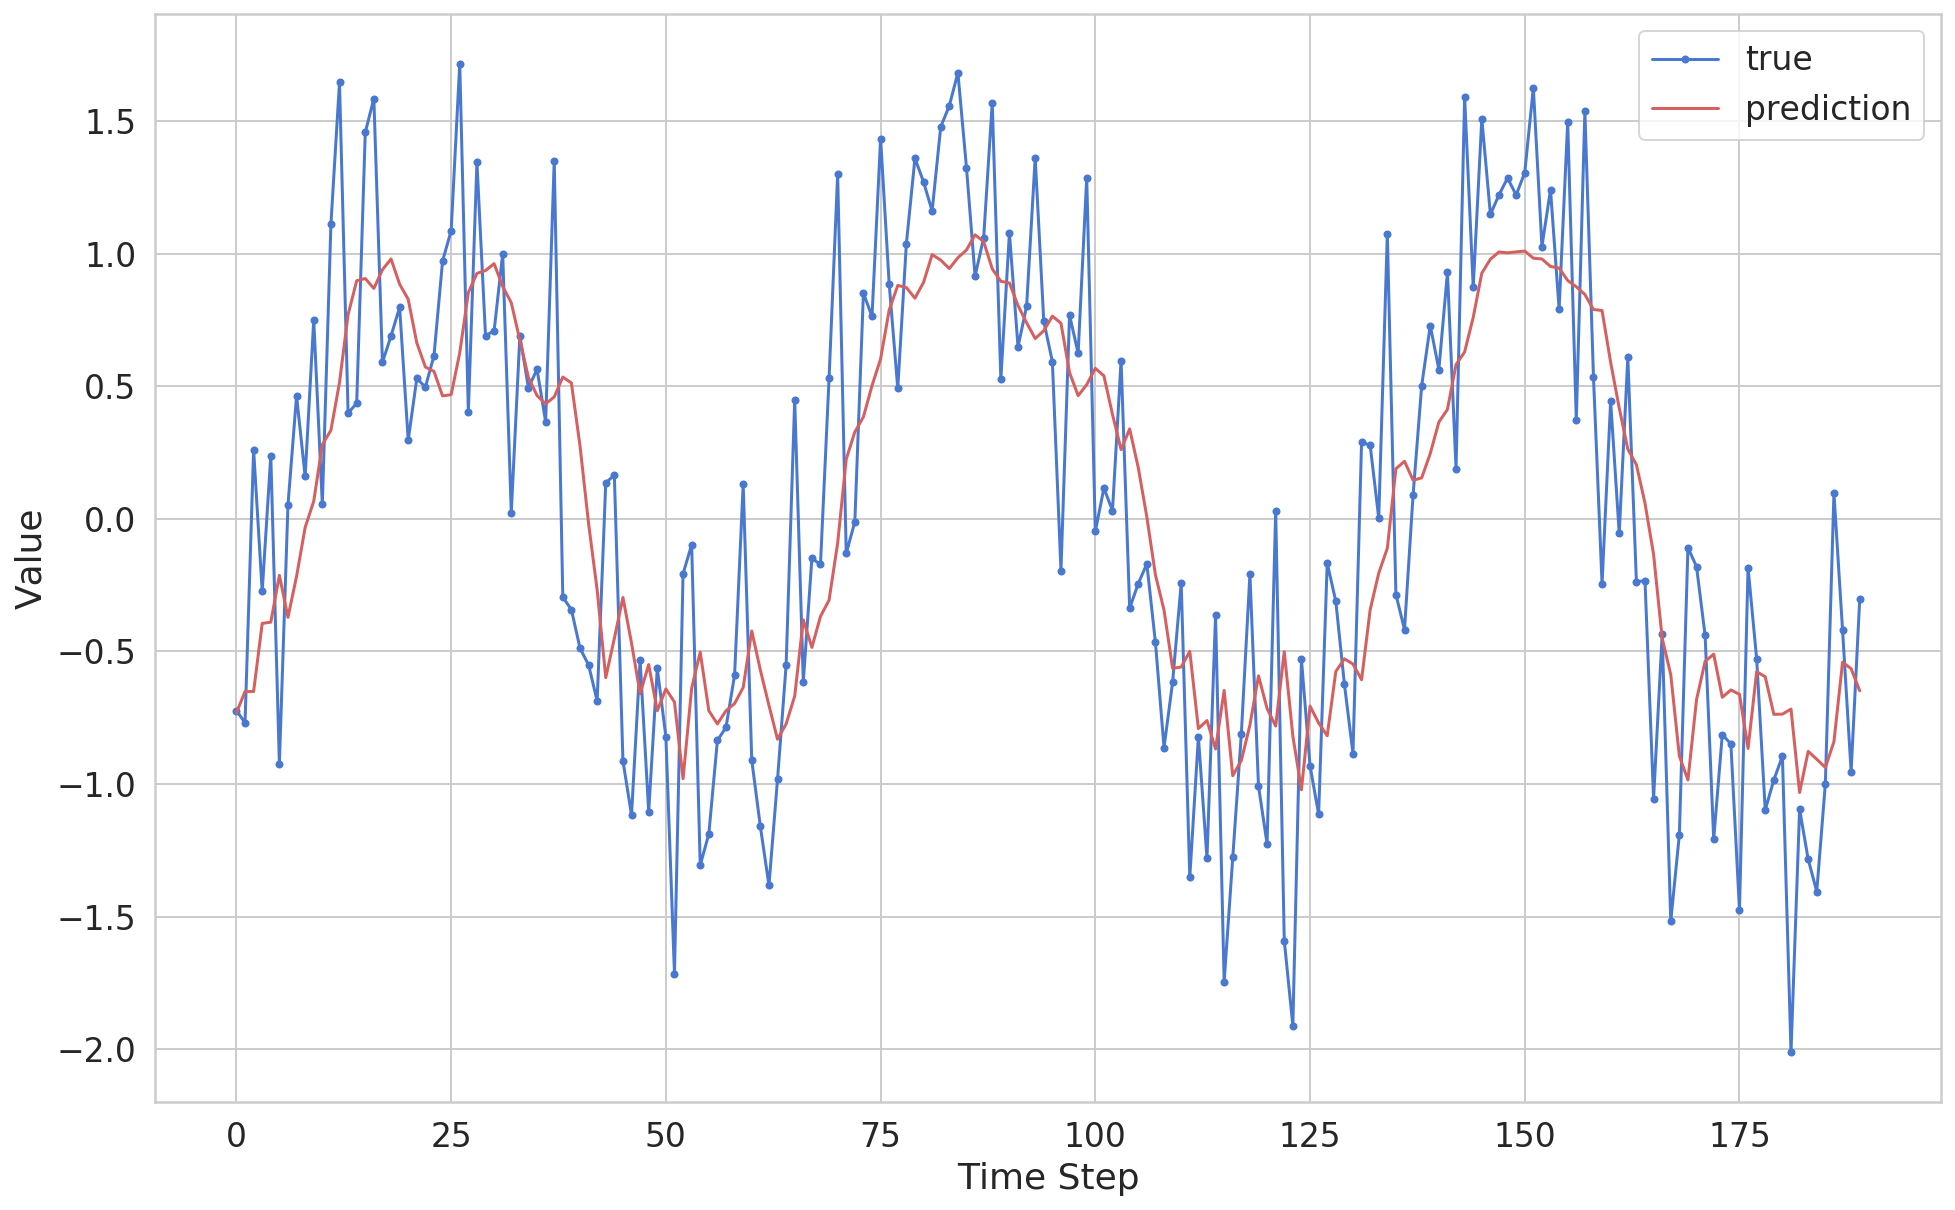

In [16]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();